# Objects Detection

> - 🤖 See [full list of Machine Learning Experiments](https://github.com/trekhleb/machine-learning-experiments) on GitHub
> - ▶️ Demo: [try this model in action](https://trekhleb.github.io/machine-learning-experiments)

_Inspired by [Objects Detection API Demo](https://colab.research.google.com/github/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb)_

## Importing Dependencies

- [tensorflow](https://www.tensorflow.org/) - for developing and training ML models.
- [matplotlib](https://matplotlib.org/) - for plotting the data.
- [numpy](https://numpy.org/) - for linear algebra operations.

In [301]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pathlib
import cv2
import math
from PIL import Image
from google.protobuf import text_format

from protos import string_int_label_map_pb2

print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Tensorflow version: 2.1.0
Keras version: 2.2.4-tf


## Loading the model

To do objects detection we're going to use [ssdlite_mobilenet_v2_coco](http://download.tensorflow.org/models/object_detection/ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz) model from [Tensorflow detection models zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md).

In [111]:
# Create cache folder.
!mkdir .tmp

mkdir: .tmp: File exists


In [112]:
def load_model(model_name):
    model_url = 'http://download.tensorflow.org/models/object_detection/' + model_name + '.tar.gz'
    
    model_dir = tf.keras.utils.get_file(
        fname=model_name, 
        origin=model_url,
        untar=True,
        cache_dir=pathlib.Path('.tmp').absolute()
    )
    model = tf.saved_model.load(model_dir + '/saved_model')
    
    return model

In [121]:
MODEL_NAME = 'ssdlite_mobilenet_v2_coco_2018_05_09'
saved_model = load_model(MODEL_NAME)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [122]:
# Exploring model signatures.
saved_model.signatures

_SignatureMap({'serving_default': <tensorflow.python.eager.wrap_function.WrappedFunction object at 0x16f1f9e50>})

In [144]:
# Loading default model signature.
model = saved_model.signatures['serving_default']

## Loading model labels

Depending on what dataset has been used to train the model we'll need to download proper labels set from [tensorflow models](https://github.com/tensorflow/models/tree/master/research/object_detection/data) repository.

The **ssdlite_mobilenet_v2_coco** model has been trained on [COCO](http://cocodataset.org) dataset which has **90** objects categories. This list of categories we're going to download and explore. We need a label file with the name [mscoco_label_map.pbtxt](https://github.com/tensorflow/models/blob/master/research/object_detection/data/mscoco_label_map.pbtxt)

In [310]:
def load_labels(labels_name):
    labels_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/' + labels_name
    
    labels_path = tf.keras.utils.get_file(
        fname=labels_name, 
        origin=labels_url,
        cache_dir=pathlib.Path('.tmp').absolute()
    )
    
    labels_file = open(labels_path, 'r')
    labels_string = labels_file.read()
    
    labels_map = string_int_label_map_pb2.StringIntLabelMap()
    try:
        text_format.Merge(labels_string, labels_map)
    except text_format.ParseError:
        labels_map.ParseFromString(labels_string)
    
    labels_dict = {}
    for item in labels_map.item:
        labels_dict[item.id] = item.display_name
    
    return labels_dict

In [311]:
LABELS_NAME = 'mscoco_label_map.pbtxt'
labels = load_labels(LABELS_NAME)
labels

{1: 'person',
 2: 'bicycle',
 3: 'car',
 4: 'motorcycle',
 5: 'airplane',
 6: 'bus',
 7: 'train',
 8: 'truck',
 9: 'boat',
 10: 'traffic light',
 11: 'fire hydrant',
 13: 'stop sign',
 14: 'parking meter',
 15: 'bench',
 16: 'bird',
 17: 'cat',
 18: 'dog',
 19: 'horse',
 20: 'sheep',
 21: 'cow',
 22: 'elephant',
 23: 'bear',
 24: 'zebra',
 25: 'giraffe',
 27: 'backpack',
 28: 'umbrella',
 31: 'handbag',
 32: 'tie',
 33: 'suitcase',
 34: 'frisbee',
 35: 'skis',
 36: 'snowboard',
 37: 'sports ball',
 38: 'kite',
 39: 'baseball bat',
 40: 'baseball glove',
 41: 'skateboard',
 42: 'surfboard',
 43: 'tennis racket',
 44: 'bottle',
 46: 'wine glass',
 47: 'cup',
 48: 'fork',
 49: 'knife',
 50: 'spoon',
 51: 'bowl',
 52: 'banana',
 53: 'apple',
 54: 'sandwich',
 55: 'orange',
 56: 'broccoli',
 57: 'carrot',
 58: 'hot dog',
 59: 'pizza',
 60: 'donut',
 61: 'cake',
 62: 'chair',
 63: 'couch',
 64: 'potted plant',
 65: 'bed',
 67: 'dining table',
 70: 'toilet',
 72: 'tv',
 73: 'laptop',
 74: 'mo

## Exploring the model

In [128]:
# List model files
!ls -la .tmp/datasets/ssdlite_mobilenet_v2_coco_2018_05_09

total 81680
drwxr-x---  9 trekhleb  staff       288 May 10  2018 .
drwxr-xr-x  4 trekhleb  staff       128 Jan 18 12:23 ..
-rw-r-----  1 trekhleb  staff        77 May 10  2018 checkpoint
-rw-r-----  1 trekhleb  staff  19911343 May 10  2018 frozen_inference_graph.pb
-rw-r-----  1 trekhleb  staff  18205188 May 10  2018 model.ckpt.data-00000-of-00001
-rw-r-----  1 trekhleb  staff     17703 May 10  2018 model.ckpt.index
-rw-r-----  1 trekhleb  staff   3665866 May 10  2018 model.ckpt.meta
-rw-r-----  1 trekhleb  staff      4199 May 10  2018 pipeline.config
drwxr-x---  4 trekhleb  staff       128 May 10  2018 saved_model


In [179]:
# Check model pipeline.
!cat .tmp/datasets/ssdlite_mobilenet_v2_coco_2018_05_09/pipeline.config

model {
  ssd {
    num_classes: 90
    image_resizer {
      fixed_shape_resizer {
        height: 300
        width: 300
      }
    }
    feature_extractor {
      type: "ssd_mobilenet_v2"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 3.99999989895e-05
          }
        }
        initializer {
          truncated_normal_initializer {
            mean: 0.0
            stddev: 0.0299999993294
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.999700009823
          center: true
          scale: true
          epsilon: 0.0010000000475
          train: true
        }
      }
      use_depthwise: true
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold:

In [146]:
model.inputs

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]

In [147]:
model.outputs

[<tf.Tensor 'detection_boxes:0' shape=(None, 100, 4) dtype=float32>,
 <tf.Tensor 'detection_classes:0' shape=(None, 100) dtype=float32>,
 <tf.Tensor 'detection_scores:0' shape=(None, 100) dtype=float32>,
 <tf.Tensor 'num_detections:0' shape=(None,) dtype=float32>]

## Loading test data

In [376]:
def display_image(image_np):
    plt.figure()
    plt.imshow(image_np)

In [159]:
TEST_IMAGES_DIR_PATH = pathlib.Path('data')
TEST_IMAGE_PATHS = sorted(list(TEST_IMAGES_DIR_PATH.glob('*.jpg')))
TEST_IMAGE_PATHS

[PosixPath('data/01.jpg'),
 PosixPath('data/02.jpg'),
 PosixPath('data/03.jpg'),
 PosixPath('data/04.jpg'),
 PosixPath('data/05.jpg'),
 PosixPath('data/06.jpg'),
 PosixPath('data/07.jpg')]

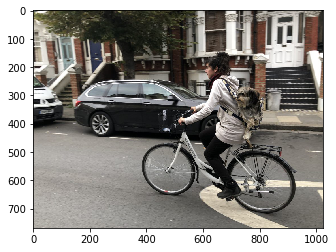

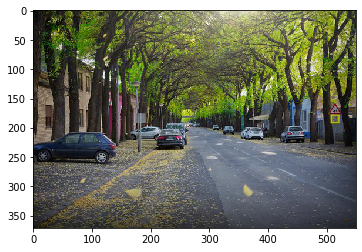

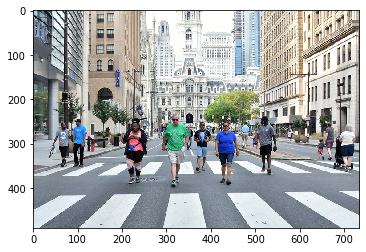

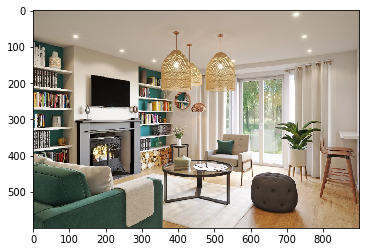

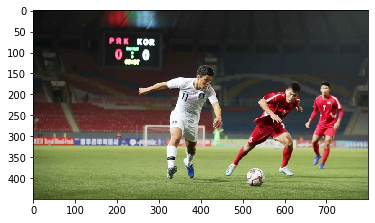

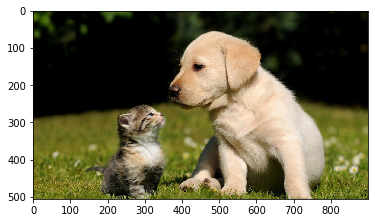

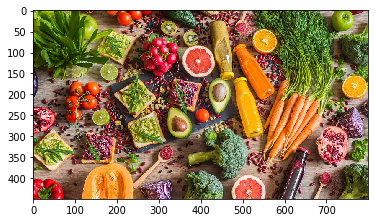

In [377]:
for image_path in TEST_IMAGE_PATHS:
    image_np = mpimg.imread(image_path)
    display_image(image_np)

## Pre-processing Test Data

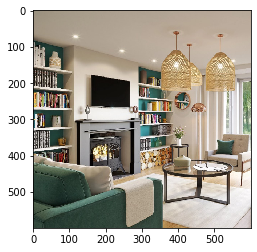

In [219]:
def preprocess_image(image_path):
#     image = cv2.imread(str(image_path))
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_np = np.array(Image.open(image_path))
    img_width, img_height, img_channels = image_np.shape
    min_dimension = min(img_width, img_height)
    cropped_image = image_np[:min_dimension,:min_dimension]
    return cropped_image
        
preprocessed_image = preprocess_image(TEST_IMAGE_PATHS[3])
display_image(preprocessed_image)

## Running the model

In [320]:
def detect_objects_on_image(image, model):
    image = np.asarray(image)
    input_tensor = tf.convert_to_tensor(image)
    # Adding one more dimension since model expect a batch of images.
    input_tensor = input_tensor[tf.newaxis, ...]

    output_dict = model(input_tensor)

    num_detections = int(output_dict['num_detections'])
    output_dict = {
        key:value[0, :num_detections].numpy() 
        for key,value in output_dict.items()
        if key != 'num_detections'
    }
    output_dict['num_detections'] = num_detections
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    
    return output_dict

In [467]:
def draw_detections_on_image(image, detections, labels):
    image_with_detections = image
    width, height, channels = image_with_detections.shape
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    color = (0, 255, 0)
    label_padding = 5
    
    num_detections = detections['num_detections']
    if num_detections > 0:
        for detection_index in range(num_detections):
            detection_score = detections['detection_scores'][detection_index]
            detection_box = detections['detection_boxes'][detection_index]
            detection_class = detections['detection_classes'][detection_index]
            detection_label = labels[detection_class]
            detection_label_full = detection_label + ' ' + str(math.floor(100 * detection_score)) + '%'
            
            y1 = int(width * detection_box[0])
            x1 = int(height * detection_box[1])
            y2 = int(width * detection_box[2])
            x2 = int(height * detection_box[3])
                        
            # Detection rectangle.    
            image_with_detections = cv2.rectangle(
                image_with_detections,
                (x1, y1),
                (x2, y2),
                color,
                3
            )
            
            # Label background.
            label_size = cv2.getTextSize(
                detection_label_full,
                cv2.FONT_HERSHEY_COMPLEX,
                0.7,
                2
            )
            
            image_with_detections = cv2.rectangle(
                image_with_detections,
                (x1, y1 - label_size[0][1] - 2 * label_padding),
                (x1 + label_size[0][0] + 2 * label_padding, y1),
                color,
                -1
            )
            
            # Label text.
            cv2.putText(
                image_with_detections,
                detection_label_full,
                (x1 + label_padding, y1 - label_padding),
                font,
                0.7,
                (0, 0, 0),
                1,
                cv2.LINE_AA
            )
            
    return image_with_detections

In [465]:
# Example of how detections dictionary looks like.
image_np = np.array(Image.open(TEST_IMAGE_PATHS[5]))
detections = detect_objects_on_image(image_np, model)
detections

{'detection_boxes': array([[0.10099357, 0.40488398, 0.98524135, 0.88602984],
        [0.5007391 , 0.16533008, 0.9958583 , 0.45117363]], dtype=float32),
 'detection_scores': array([0.889021 , 0.3024035], dtype=float32),
 'detection_classes': array([18, 17]),
 'num_detections': 2}

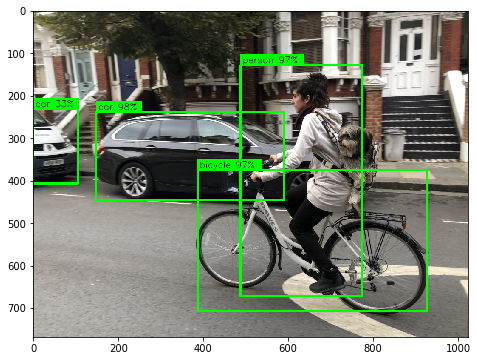

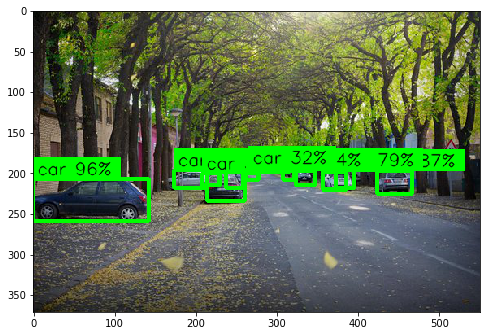

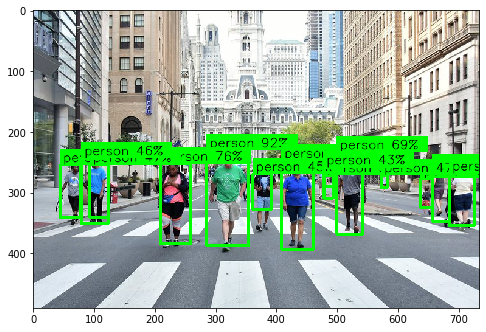

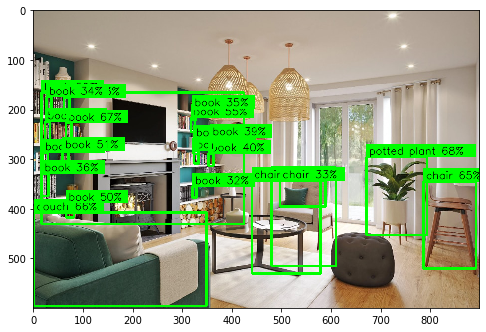

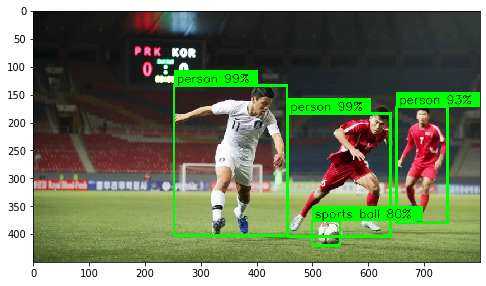

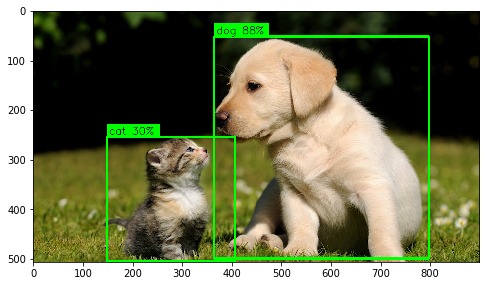

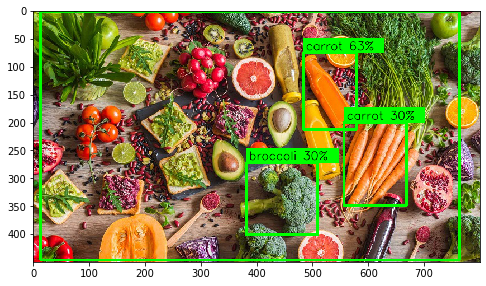

In [468]:
for image_path in TEST_IMAGE_PATHS:
    image_np = np.array(Image.open(image_path))
    detections = detect_objects_on_image(image_np, model)
    image_with_detections = draw_detections_on_image(image_np, detections, labels)
    plt.figure(figsize=(8, 6))
    plt.imshow(image_with_detections)

## Converting the model to web-format

To use the `ssdlite_mobilenet_v2_coco_2018_05_09` model on the web we need to convert it into the format that will be understandable by [tensorflowjs](https://www.tensorflow.org/js). To do so we may use [tfjs-converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) as following:

```
tensorflowjs_converter --input_format=tf_saved_model \
                       --output_format=tfjs_graph_model \
                       --output_node_names='Postprocessor/ExpandDims_1,Postprocessor/Slice' \
                       ./experiments/digits_recognition_mlp/digits_recognition_mlp.h5 \
                       ./demos/public/models/digits_recognition_mlp
```

Alternative and easier way would be to use a [@tensorflow-models/coco-ssd](https://www.npmjs.com/package/@tensorflow-models/coco-ssd) npm package. But just for exploration purpose let's go one level deeper and use the model directly without wrapper modules.

```
tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    ./experiments/objects_detection/.tmp/datasets/ssdlite_mobilenet_v2_coco_2018_05_09/saved_model \
    ./demos/public/models/objects_detection
```

In [20]:
# This line is slow and heavy but contains a lot of info about the model.
# model_signature.function_def